# Crypto-Assets Cointegration Project

### Modules

In [122]:
import binance_api
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
# https://www.marketcalls.in/amibroker/computing-cointegration-and-augmented-dickey-fuller-test-in-amibroker-using-python.html#:~:text=Augmented%20Dicky%20Fuller%20test%20is,stationary%20and%20cointegrated%20or%20not.&text=The%20Augmented%20Dicky%20Fuller%20test,want%20to%20reject%20this%20hypothesis.


### Default Values

In [123]:
# default values
nbr_of_coins = 20

interval_long = '1h'
interval_mid ='15m'
interval_short = '5m'

# lookback periods are in days
lookback_long = 40 * 24
lookback_mid = 10 * 4 * 24
lookback_short = 3 * 12 * 24

#startTime = round(datetime(2021, 12, 5).timestamp()) * 1000
endTime = round(datetime(2022, 2, 16).timestamp()) * 1000

### Get coins with most volume on Binance

In [124]:
# Get all coins, sort them by volume and keep the top x nbr of coins
tickers = pd.DataFrame(binance_api.get_all_tickers())
tickers['volume_usd'] = tickers.apply(lambda row: float(row['volume']) * float(row['lastPrice']), axis=1)
tickers = tickers.sort_values(by='volume_usd', ascending=False)
top_tickers = tickers[:nbr_of_coins]

# Remove PEOPLE because its missing some data
top_tickers = top_tickers[top_tickers['symbol'] != 'PEOPLEUSDT']
top_tickers = top_tickers[top_tickers['symbol'] != 'BTCUSDT_220325']
top_tickers = top_tickers[top_tickers['symbol'] != 'ROSEUSDT']
top_tickers = top_tickers[top_tickers['symbol'] != 'API3USDT']
print(top_tickers['symbol'].values.tolist())

['BTCUSDT', 'ETHUSDT', 'LUNAUSDT', 'BTCBUSD', 'SOLUSDT', 'GALAUSDT', '1000SHIBUSDT', 'AVAXUSDT', 'ADAUSDT', 'XRPUSDT', 'FTMUSDT', 'ETHBUSD', 'SANDUSDT', 'MANAUSDT', 'BNBUSDT', 'MATICUSDT', 'DOTUSDT', 'ATOMUSDT', 'LINKUSDT', 'DOGEUSDT']


In [125]:
top_tickers['symbol'].values.tolist()[14]

'BNBUSDT'

### Historical Data

In [126]:
# Get historical data for multiple timeframes

# short
historical_data_short = {}
for i in range(0, len(top_tickers)):
    historical_data_short[top_tickers.iloc[i]['symbol']] = pd.DataFrame(binance_api.get_historical_prices(top_tickers.iloc[i]['symbol'], interval_short, None, endTime))
print('Downloaded {} data'.format(interval_short))

# mid
historical_data_mid = {}
for i in range(0, len(top_tickers)):
    historical_data_mid[top_tickers.iloc[i]['symbol']] = pd.DataFrame(binance_api.get_historical_prices(top_tickers.iloc[i]['symbol'], interval_mid, None, endTime))
print('Downloaded {} data'.format(interval_mid))


# long
historical_data_long = {}
for i in range(0, len(top_tickers)):
    historical_data_long[top_tickers.iloc[i]['symbol']] = pd.DataFrame(binance_api.get_historical_prices(top_tickers.iloc[i]['symbol'], interval_long, None, endTime))
print('Downloaded {} data'.format(interval_long))


Downloaded 5m data
Downloaded 15m data
Downloaded 1h data


In [127]:
# Data Sample
historical_data_long['ETHUSDT']

,0,1,2,3,4,5,6,7,8,9,10,11
0,1641391200000,3813.26,3833.55,3788.00,3820.34,99714.755,1641394799999,379866508.42199,117479,50394.042,192015794.89271,0
1,1641394800000,3820.34,3827.74,3803.87,3819.25,40504.986,1641398399999,154543684.72704,62450,19532.979,74537276.44313,0
2,1641398400000,3819.25,3821.70,3790.00,3792.03,38719.760,1641401999999,147330964.81001,57502,17055.753,64909531.45945,0
3,1641402000000,3792.02,3803.00,3770.00,3771.55,38219.240,1641405599999,144778261.99107,53158,15985.157,60579229.26012,0
4,1641405600000,3771.74,3772.72,3724.83,3746.78,133617.982,1641409199999,500639035.92195,160994,61527.606,230536331.71762,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1644973200000,3160.48,3160.70,3132.50,3138.17,57977.129,1644976799999,182407812.34886,78938,26873.462,84560735.49909,0
996,1644976800000,3138.17,3157.44,3135.17,3154.30,36580.924,1644980399999,114992105.12841,52260,20681.508,65026067.16832,0
997,1644980400000,3154.31,3174.34,3137.71,3140.61,62741.539,1644983999999,197964659.89886,76406,29417.962,92824279.34690,0
998,1644984000000,3140.61,3140.88,3105.11,3123.81,85453.568,1644987599999,266677927.95777,102242,42793.076,133532871.24179,0


### Cointegration Example

In [134]:
# Engler-Granger Test
data_1 = np.asarray(historical_data_short['BTCUSDT'][4].tail(lookback_short)).astype(float)
data_2 = np.asarray(historical_data_short['ETHUSDT'][4].tail(lookback_short)).astype(float)
result = stat.OLS(data_1, data_2).fit()
a = ts.adfuller(result.resid)
print('engler-granger p-value: {}'.format(a[1]))

# Johansen Test
df = pd.DataFrame({'x':data_1, 'y': data_2})
jres = coint_johansen(df, 0, 1)
print('johansen trace: {}, critical values: {}'.format(jres.trace_stat, jres.cvt))

engler-granger p-value: 0.9210997917070824
johansen trace: [9.72443745 0.81253474], critical values: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


### Cointegration Matrix

<AxesSubplot:title={'center':'1h resolution'}>

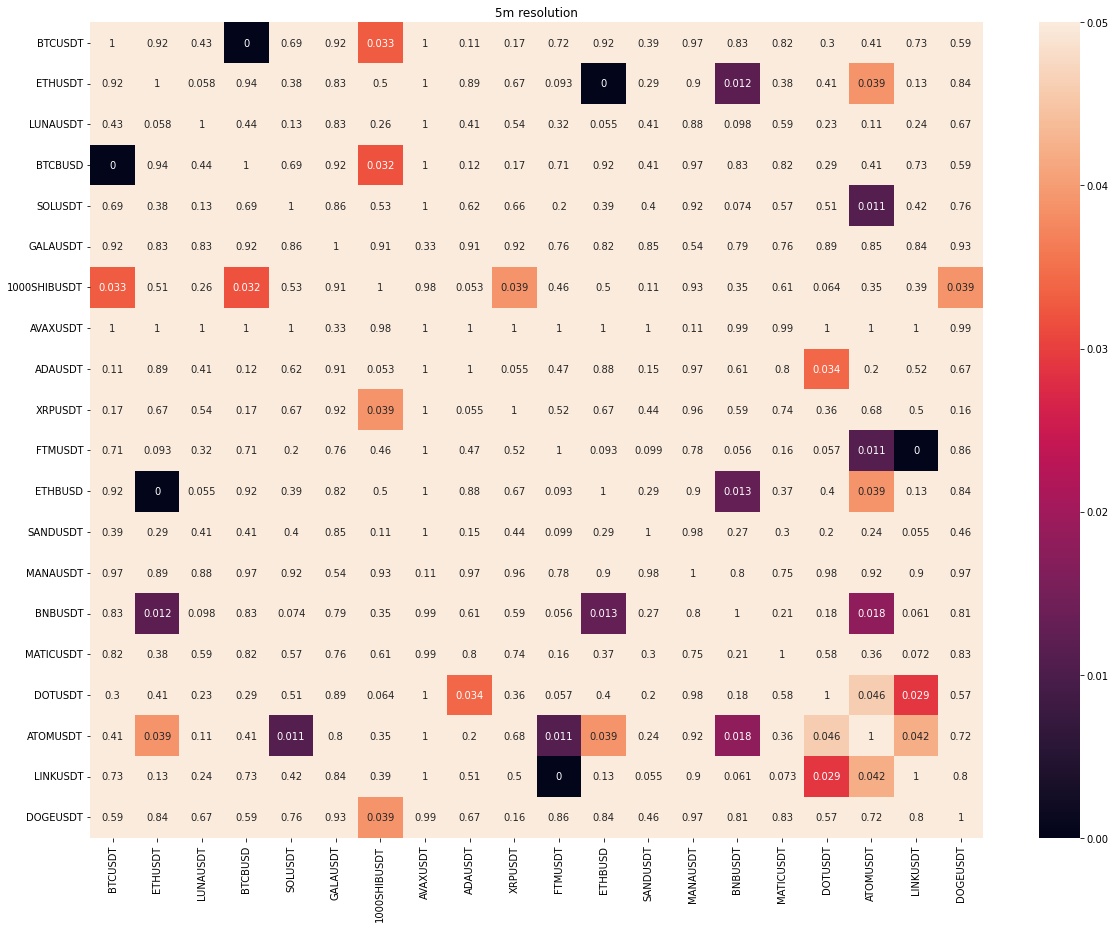

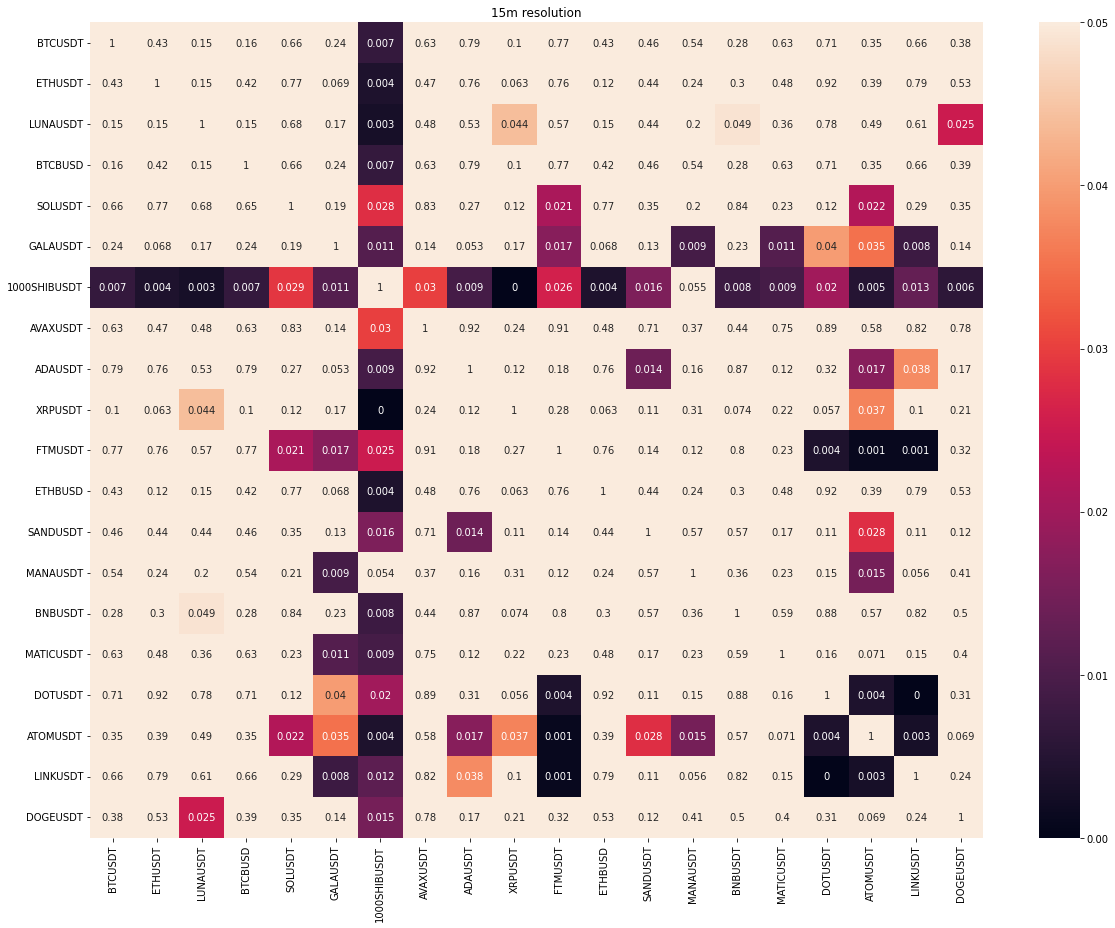

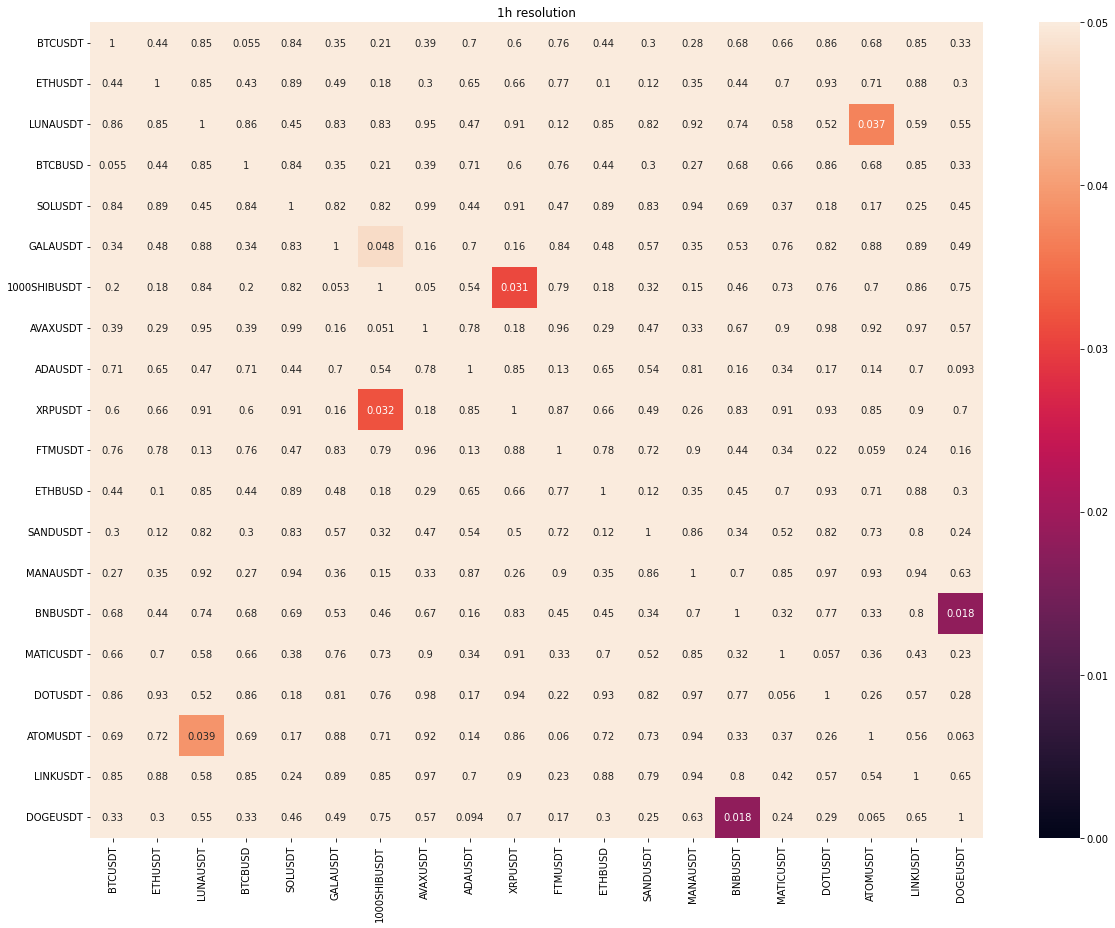

In [129]:
symbols = list(historical_data_short.keys())

# short
coint_matrix_short = pd.DataFrame(index=symbols, columns=symbols)
for i in range(0, len(coint_matrix_short)):
    for j in range(0, len(coint_matrix_short)):
        if i != j:
            #print('{},{}'.format(i,j))
            data_1 = np.asarray(historical_data_short[coint_matrix_short.index[i]][4].tail(lookback_short)).astype(float)
            data_2 = np.asarray(historical_data_short[coint_matrix_short.index[j]][4].tail(lookback_short)).astype(float)
            if len(data_1) == len(data_2):
                result = stat.OLS(data_1, data_2).fit()
                a = ts.adfuller(result.resid)
                pvalue = a[1]
                coint_matrix_short[coint_matrix_short.index[i]][coint_matrix_short.index[j]] = round(pvalue, 3)

coint_matrix_short = coint_matrix_short.fillna(1)

# Show
plt.figure(figsize=(20,15))
plt.title('{} resolution'.format(interval_short))
sb.heatmap(coint_matrix_short, annot=True, vmin=0, vmax=0.05)


# mid
coint_matrix_mid = pd.DataFrame(index=symbols, columns=symbols)
for i in range(0, len(coint_matrix_mid)):
    for j in range(0, len(coint_matrix_mid)):
        if i != j:
            #print('{},{}'.format(i,j))
            data_1 = np.asarray(historical_data_mid[coint_matrix_mid.index[i]][4].tail(lookback_mid)).astype(float)
            data_2 = np.asarray(historical_data_mid[coint_matrix_mid.index[j]][4].tail(lookback_mid)).astype(float)
            if len(data_1) == len(data_2):
                result = stat.OLS(data_1, data_2).fit()
                a = ts.adfuller(result.resid)
                pvalue = a[1]
                coint_matrix_mid[coint_matrix_mid.index[i]][coint_matrix_mid.index[j]] = round(pvalue, 3)

coint_matrix_mid = coint_matrix_mid.fillna(1)

# Show
plt.figure(figsize=(20,15))
plt.title('{} resolution'.format(interval_mid))
sb.heatmap(coint_matrix_mid, annot=True, vmin=0, vmax=0.05)

# long
coint_matrix_long = pd.DataFrame(index=symbols, columns=symbols)
for i in range(0, len(coint_matrix_long)):
    for j in range(0, len(coint_matrix_long)):
        if i != j:
            #print('{},{}'.format(i,j))
            data_1 = np.asarray(historical_data_long[coint_matrix_long.index[i]][4].tail(lookback_long)).astype(float)
            data_2 = np.asarray(historical_data_long[coint_matrix_long.index[j]][4].tail(lookback_long)).astype(float)
            if len(data_1) == len(data_2):
                result = stat.OLS(data_1, data_2).fit()
                a = ts.adfuller(result.resid)
                pvalue = a[1]
                coint_matrix_long[coint_matrix_long.index[i]][coint_matrix_long.index[j]] = round(pvalue, 3)

coint_matrix_long = coint_matrix_long.fillna(1)

# Show
plt.figure(figsize=(20,15))
plt.title('{} resolution'.format(interval_long))
sb.heatmap(coint_matrix_long, annot=True, vmin=0, vmax=0.05)



In [130]:
# Stats
nbr_of_cointegrated_pairs = coint_matrix_short[coint_matrix_short < 0.05].count().sum() / 2
nbr_of_pairs = coint_matrix_long.size / 2
percentage_of_cointegration = nbr_of_cointegrated_pairs / nbr_of_pairs * 100
print('{:.2f}% of the most liquid pairs are cointegrated on the {} data'.format(percentage_of_cointegration, interval_short))

nbr_of_cointegrated_pairs = coint_matrix_mid[coint_matrix_mid < 0.05].count().sum() / 2
nbr_of_pairs = coint_matrix_mid.size / 2
percentage_of_cointegration = nbr_of_cointegrated_pairs / nbr_of_pairs * 100
print('{:.2f}% of the most liquid pairs are cointegrated on the {} data'.format(percentage_of_cointegration, interval_mid))

nbr_of_cointegrated_pairs = coint_matrix_long[coint_matrix_long < 0.05].count().sum() / 2
nbr_of_pairs = coint_matrix_long.size / 2
percentage_of_cointegration = nbr_of_cointegrated_pairs / nbr_of_pairs * 100
print('{:.2f}% of the most liquid pairs are cointegrated on the {} data'.format(percentage_of_cointegration, interval_long))


9.00% of the most liquid pairs are cointegrated on the 5m data
20.50% of the most liquid pairs are cointegrated on the 15m data
1.75% of the most liquid pairs are cointegrated on the 1h data


## Pairs cointegrated on different timeframe 

In [131]:
for i in range(0, len(coint_matrix_long)):
    for j in range(0, len(coint_matrix_long)):
        if coint_matrix_long.iloc[i][j] < 0.05 and coint_matrix_mid.iloc[i][j] < 0.05 and coint_matrix_short.iloc[i][j] < 0.05:
            print('{}/{} pair is cointegrated in 3 timeframes'.format(coint_matrix_long.index[i],coint_matrix_long.index[j]))
            
    

1000SHIBUSDT/XRPUSDT pair is cointegrated in 3 timeframes
XRPUSDT/1000SHIBUSDT pair is cointegrated in 3 timeframes


In [132]:
for i in range(0, len(coint_matrix_long)):
    for j in range(0, len(coint_matrix_long)):
        if coint_matrix_mid.iloc[i][j] < 0.05 and coint_matrix_short.iloc[i][j] < 0.05:
            print('{}/{} pair is cointegrated in 2 timeframes'.format(coint_matrix_long.index[i],coint_matrix_long.index[j]))
            
    

BTCUSDT/1000SHIBUSDT pair is cointegrated in 2 timeframes
BTCBUSD/1000SHIBUSDT pair is cointegrated in 2 timeframes
SOLUSDT/ATOMUSDT pair is cointegrated in 2 timeframes
1000SHIBUSDT/BTCUSDT pair is cointegrated in 2 timeframes
1000SHIBUSDT/BTCBUSD pair is cointegrated in 2 timeframes
1000SHIBUSDT/XRPUSDT pair is cointegrated in 2 timeframes
1000SHIBUSDT/DOGEUSDT pair is cointegrated in 2 timeframes
XRPUSDT/1000SHIBUSDT pair is cointegrated in 2 timeframes
FTMUSDT/ATOMUSDT pair is cointegrated in 2 timeframes
FTMUSDT/LINKUSDT pair is cointegrated in 2 timeframes
DOTUSDT/ATOMUSDT pair is cointegrated in 2 timeframes
DOTUSDT/LINKUSDT pair is cointegrated in 2 timeframes
ATOMUSDT/SOLUSDT pair is cointegrated in 2 timeframes
ATOMUSDT/FTMUSDT pair is cointegrated in 2 timeframes
ATOMUSDT/DOTUSDT pair is cointegrated in 2 timeframes
ATOMUSDT/LINKUSDT pair is cointegrated in 2 timeframes
LINKUSDT/FTMUSDT pair is cointegrated in 2 timeframes
LINKUSDT/DOTUSDT pair is cointegrated in 2 timeframe